In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [ ]:
model_names = ['microsoft/Phi-4-mini-instruct',
               'meta-llama/Llama-3.2-3B-Instruct',
               'google/gemma-3-4b-it']

##### attention_flow

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = 'microsoft/Phi-4-mini-instruct'
# model_name = 'meta-llama/Llama-3.2-3B-Instruct'
# model_name = 'google/gemma-3-4b-it'
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             device_map = device,
                                             torch_dtype = torch.bfloat16)

# Prepare input
prompt = "You are very knowledgeable in geography. What is the capital of France? Only answer the question with the exact word as the answer, and do not output any other word."
# inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
inputs = tokenizer(prompt, return_tensors = "pt", add_special_tokens = False).to(model.device)

# Forward pass with attention capture
with torch.no_grad():
    outputs = model(**inputs,
                    output_attentions = True,
                    max_new_tokens = 2)

# Get attention matrices
attentions = outputs.attentions  # Tuple of layer outputs
input_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Initialize aggregation tensor
total_attention_flow = torch.zeros(len(input_tokens))

# Process each layer's attention
for layer_idx, layer_attn in enumerate(attentions):
    # layer_attn shape: (batch_size, num_heads, seq_len, seq_len)
    layer_attn = layer_attn.squeeze(0)  # Remove batch dimension
    
    # Focus on attention to last output position (where "Paris" is generated)
    # Average across attention heads
    head_aggregated = layer_attn[:, -1, :].mean(dim=0)  # (seq_len,)
    
    total_attention_flow += head_aggregated.cpu()

# Normalize
total_attention_flow /= len(attentions)

# Display results
for token, score in zip(input_tokens, total_attention_flow):
    print(f"{token}: {score.item():.4f}")

generated_ids = inputs.input_ids[0].tolist()
all_attentions = []

for _ in range(2):  # Generate 2 tokens
    current_ids = torch.tensor([generated_ids]).to(model.device)
    outputs = model(input_ids=current_ids, output_attentions=True)
    
    # Get next token
    next_token_id = torch.argmax(outputs.logits[0, -1, :]).item()
    generated_ids.append(next_token_id)
    all_attentions.append(outputs.attentions)
    
    # Optional: print each generated token
    token = tokenizer.decode(next_token_id)
    print(f"Generated token: '{token}'")

# Decode full sequence
full_text = tokenizer.decode(generated_ids)
print(f"\nFull text: {full_text}")

# # Option 2: Use generate() as in the original code
# outputs = model.generate(
#     **inputs,
#     max_new_tokens=2,
#     output_attentions=True,
#     return_dict_in_generate=True,
#     do_sample=False
# )
# generated_text = tokenizer.decode(outputs.sequences[0])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


You: 0.5287
Ġare: 0.0035
Ġvery: 0.0015
Ġknowledgeable: 0.0023
Ġin: 0.0025
Ġgeography: 0.0057
.: 0.0257
ĠWhat: 0.0101
Ġis: 0.0048
Ġthe: 0.0281
Ġcapital: 0.0204
Ġof: 0.0116
ĠFrance: 0.0215
?: 0.0351
ĠOnly: 0.0086
Ġanswer: 0.0103
Ġthe: 0.0108
Ġquestion: 0.0104
Ġwith: 0.0071
Ġthe: 0.0218
Ġexact: 0.0072
Ġword: 0.0125
Ġas: 0.0055
Ġthe: 0.0054
Ġanswer: 0.0140
,: 0.0209
Ġand: 0.0084
Ġdo: 0.0074
Ġnot: 0.0089
Ġoutput: 0.0096
Ġany: 0.0060
Ġother: 0.0084
Ġword: 0.0184
.: 0.0968
Generated token: ' Paris'
Generated token: '.'

Full text: You are very knowledgeable in geography. What is the capital of France? Only answer the question with the exact word as the answer, and do not output any other word. Paris.


##### causal tracing - gemini

Using device: cuda
Clean prompt tokens: ['You', ' are', ' very', ' knowledgeable', ' in', ' geography', '.', ' What', ' is', ' the', ' capital', ' fo', ' France', '?']
Clean run: Probability of 'Paris' (ID: 40313): 0.0000
Key token indices in prompt to trace: [10, 12] ([' capital', ' France'])
Corrupted run (baseline): Probability of 'Paris': 0.0000

--- Tracing Layer: Embeddings (input to Layer 0) ---
  Effect of restoring embeddings for key tokens: 0.0000 (Prob: 0.0000)

--- Tracing Layer: 0 ---
  Effect of restoring state for key tokens at output of layer 0: 0.0000 (Prob: 0.0000)

--- Tracing Layer: 1 ---
  Effect of restoring state for key tokens at output of layer 1: 0.0000 (Prob: 0.0000)

--- Tracing Layer: 2 ---
  Effect of restoring state for key tokens at output of layer 2: 0.0000 (Prob: 0.0000)

--- Tracing Layer: 3 ---
  Effect of restoring state for key tokens at output of layer 3: 0.0000 (Prob: 0.0000)

--- Tracing Layer: 4 ---
  Effect of restoring state for key tokens at

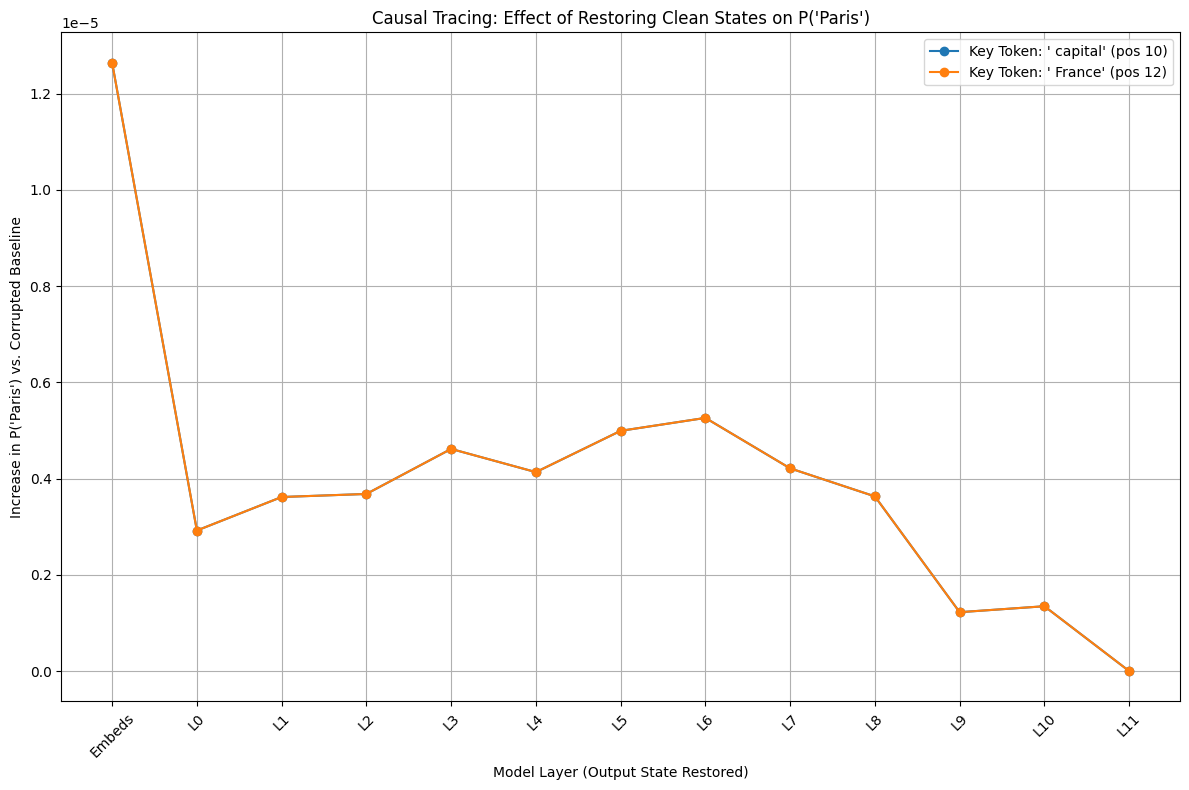

In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt

# --- Helper function to get transformer blocks ---
def get_transformer_layers(model):
    if hasattr(model, 'transformer') and hasattr(model.transformer, 'h'): # GPT-2 like
        return model.transformer.h
    elif hasattr(model, 'model') and hasattr(model.model, 'layers'): # Gemma, Llama like
        return model.model.layers
    elif hasattr(model, 'gpt_neox') and hasattr(model.gpt_neox, 'layers'): # GPT-NeoX like
        return model.gpt_neox.layers
    else:
        raise ValueError("Unsupported model architecture for layer extraction. Please adapt.")

# --- Global variable for hook ---
# This is a simple way to pass data to the hook. For more complex scenarios,
# you might use a class or functools.partial.
global_hook_data = {
    "clean_state_to_inject": None,
    "target_token_indices_in_sequence": None, # Which token(s) in the sequence to patch
    "active": False
}

def intervention_hook(module, inputs, outputs):
    """
    This hook is attached to the *output* of a transformer layer.
    It replaces the hidden state of the target token(s) in the output
    with the clean state *before* it's passed to the next layer.
    Alternatively, one could hook the *input* to the *next* layer.
    Hooking the output of the current layer is often cleaner.
    """
    if global_hook_data["active"]:
        # `outputs` can be a tensor or a tuple (tensor, present_key_value). We want the tensor.
        hidden_states_output = outputs[0] if isinstance(outputs, tuple) else outputs

        # Create a new tensor to avoid in-place modification issues with hooks
        modified_hidden_states = hidden_states_output.clone()

        # Inject the clean state for the specified token(s)
        # global_hook_data["clean_state_to_inject"] is (1, num_tokens_to_patch, hidden_dim)
        # hidden_states_output is (batch_size, seq_len, hidden_dim)
        # We assume batch_size = 1 for this causal tracing setup.
        for i, token_idx_in_seq in enumerate(global_hook_data["target_token_indices_in_sequence"]):
            modified_hidden_states[0, token_idx_in_seq, :] = global_hook_data["clean_state_to_inject"][0, i, :]
        
        if isinstance(outputs, tuple):
            return (modified_hidden_states,) + outputs[1:]
        else:
            return modified_hidden_states
    return outputs


def run_model_and_get_states_and_logits(model, input_ids, attention_mask=None):
    """Runs the model and returns all hidden states and the logits for the next token."""
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
    # hidden_states[0] = embeddings, hidden_states[1] = layer 0 output, ...
    all_hidden_states = outputs.hidden_states
    # Logits for the token *after* the last input token
    next_token_logits = outputs.logits[0, -1, :]
    return all_hidden_states, next_token_logits


def causal_tracing(model_name, prompt, target_fact_answer, key_token_strs_in_prompt, noise_level=0.1):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).to(device)
    model.eval()

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # --- 1. Clean Run ---
    inputs_clean = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids_clean = inputs_clean.input_ids
    attention_mask_clean = inputs_clean.attention_mask
    prompt_tokens_decoded = [tokenizer.decode(id) for id in input_ids_clean[0]]
    print(f"Clean prompt tokens: {prompt_tokens_decoded}")

    hidden_states_clean, logits_clean = run_model_and_get_states_and_logits(model, input_ids_clean, attention_mask_clean)
    prob_clean = F.softmax(logits_clean, dim=-1)
    
    # Get target token ID (e.g., "Paris")
    # Important: target_fact_answer might be tokenized differently based on context.
    # For " Paris" vs "Paris", we'll try to be robust.
    target_token_id_candidate = tokenizer.encode(target_fact_answer, add_special_tokens=False)
    if not target_token_id_candidate:
        print(f"Could not encode target fact answer '{target_fact_answer}'")
        # Try with a leading space
        target_token_id_candidate = tokenizer.encode(" " + target_fact_answer, add_special_tokens=False)
        if not target_token_id_candidate:
            return None
    target_token_id = target_token_id_candidate[0] # Assume first token if multi-token
    
    prob_target_clean = prob_clean[target_token_id].item()
    print(f"Clean run: Probability of '{tokenizer.decode(target_token_id)}' (ID: {target_token_id}): {prob_target_clean:.4f}")

    # Identify indices of key_token_strs in the prompt
    key_token_indices_in_prompt = []
    for key_str in key_token_strs_in_prompt:
        # This is a simple search; for subword tokenization, it might need refinement
        # to find the first subword of the key_str.
        for i, token_str in enumerate(prompt_tokens_decoded):
            # Check if key_str (potentially with a leading space for robustness) is in the token_str
            # This handles cases where tokenizer adds a prefix like 'Ġ'
            if key_str.strip() in token_str.strip() and i not in key_token_indices_in_prompt:
                key_token_indices_in_prompt.append(i)
                break
    if not key_token_indices_in_prompt:
        print(f"Could not find key tokens {key_token_strs_in_prompt} in prompt tokens {prompt_tokens_decoded}. Please check.")
        return
    print(f"Key token indices in prompt to trace: {key_token_indices_in_prompt} ({[prompt_tokens_decoded[i] for i in key_token_indices_in_prompt]})")


    # --- 2. Corrupted Run (Noisy Embeddings) ---
    # Get embeddings from the clean input
    with torch.no_grad():
        clean_embeddings = model.get_input_embeddings()(input_ids_clean) # (batch, seq_len, hidden_dim)

    # Add noise
    noise = torch.randn_like(clean_embeddings) * noise_level
    corrupted_embeddings = clean_embeddings + noise

    # Run model with corrupted embeddings (inputs_embeds)
    with torch.no_grad():
        outputs_corrupted_baseline = model(inputs_embeds=corrupted_embeddings, attention_mask=attention_mask_clean, output_hidden_states=False) # No need for hidden states here yet
    logits_corrupted_baseline = outputs_corrupted_baseline.logits[0, -1, :]
    prob_corrupted_baseline = F.softmax(logits_corrupted_baseline, dim=-1)
    prob_target_corrupted_baseline = prob_corrupted_baseline[target_token_id].item()
    print(f"Corrupted run (baseline): Probability of '{tokenizer.decode(target_token_id)}': {prob_target_corrupted_baseline:.4f}")


    # --- 3. Intervention Loop ---
    transformer_layers = get_transformer_layers(model)
    num_layers = len(transformer_layers)
    causal_effects = np.zeros((num_layers + 1, len(key_token_indices_in_prompt))) # +1 for embedding layer

    # Store hook handles to remove them later
    hook_handles = []

    # A. Intervening at the Embedding Layer Output (input to first transformer block)
    # The state to inject is hidden_states_clean[0] (embedding output)
    # We are modifying the *input* to the very first transformer block.
    # This is equivalent to directly using the clean embeddings for the key tokens
    # while other tokens remain corrupted.
    print(f"\n--- Tracing Layer: Embeddings (input to Layer 0) ---")
    current_clean_state_slice = hidden_states_clean[0][0, key_token_indices_in_prompt, :].unsqueeze(0) # (1, num_key_tokens, hidden_dim)
    
    # Create a new corrupted_embeddings tensor for this specific intervention
    intervened_embeddings = corrupted_embeddings.clone()
    intervened_embeddings[0, key_token_indices_in_prompt, :] = current_clean_state_slice[0, :, :]

    with torch.no_grad():
        outputs_intervened = model(inputs_embeds=intervened_embeddings, attention_mask=attention_mask_clean)
    logits_intervened = outputs_intervened.logits[0, -1, :]
    prob_intervened = F.softmax(logits_intervened, dim=-1)
    prob_target_intervened = prob_intervened[target_token_id].item()
    
    # Store effect for each key token (though we patch them all at once here for embeddings)
    # The effect is the increase in probability compared to the corrupted baseline
    effect = prob_target_intervened - prob_target_corrupted_baseline
    for k_idx in range(len(key_token_indices_in_prompt)):
        causal_effects[0, k_idx] = effect # Assign the same effect to all key tokens for embedding layer
    print(f"  Effect of restoring embeddings for key tokens: {effect:.4f} (Prob: {prob_target_intervened:.4f})")


    # B. Intervening at the Output of Each Transformer Layer
    for layer_idx in range(num_layers):
        target_transformer_layer = transformer_layers[layer_idx]
        print(f"\n--- Tracing Layer: {layer_idx} ---")

        # The clean state to inject is the *output* of this layer from the clean run.
        # hidden_states_clean[0] is embeddings, hidden_states_clean[1] is output of layer 0, etc.
        # So, for layer_idx, we need hidden_states_clean[layer_idx + 1]
        current_clean_state_slice = hidden_states_clean[layer_idx + 1][0, key_token_indices_in_prompt, :].unsqueeze(0)

        global_hook_data["clean_state_to_inject"] = current_clean_state_slice.to(device)
        global_hook_data["target_token_indices_in_sequence"] = key_token_indices_in_prompt
        global_hook_data["active"] = True

        handle = target_transformer_layer.register_forward_hook(intervention_hook)
        hook_handles.append(handle)

        # Run with corrupted embeddings, hook will modify the state at target_transformer_layer's output
        with torch.no_grad():
            outputs_intervened = model(inputs_embeds=corrupted_embeddings, attention_mask=attention_mask_clean)
        logits_intervened = outputs_intervened.logits[0, -1, :]
        prob_intervened = F.softmax(logits_intervened, dim=-1)
        prob_target_intervened = prob_intervened[target_token_id].item()

        # Remove hook immediately
        handle.remove()
        global_hook_data["active"] = False # Deactivate hook logic

        effect = prob_target_intervened - prob_target_corrupted_baseline
        # For simplicity, if we patch multiple key tokens, we can average the effect or report per token
        # Here, we attribute the combined effect to each key token's "slot" for this layer.
        # A more granular approach would intervene on one key token at a time.
        for k_idx in range(len(key_token_indices_in_prompt)):
            causal_effects[layer_idx + 1, k_idx] = effect
        print(f"  Effect of restoring state for key tokens at output of layer {layer_idx}: {effect:.4f} (Prob: {prob_target_intervened:.4f})")

    # Clean up any remaining hooks just in case (though they should be removed in the loop)
    for h in hook_handles:
        h.remove()
    global_hook_data["active"] = False
    global_hook_data["clean_state_to_inject"] = None
    global_hook_data["target_token_indices_in_sequence"] = None

    return causal_effects, prompt_tokens_decoded, key_token_indices_in_prompt, target_token_id, tokenizer


if __name__ == '__main__':
    # model_name = "google/gemma-2b-it"
    model_name = "gpt2" # Using GPT-2 for broader compatibility and faster testing
    
    # User's prompt with the typo "fo"
    prompt = "You are very knowledgeable in geography. What is the capital fo France?"
    target_fact_answer = "Paris" # The actual correct token the model should predict
    
    # Key tokens in the prompt that are likely related to the fact.
    # We will trace the effect of restoring their hidden states.
    key_token_strs_in_prompt = ["capital", "France"] # Case-sensitive, ensure they match tokenizer output

    results = causal_tracing(model_name, prompt, target_fact_answer, key_token_strs_in_prompt, noise_level=0.1)

    if results:
        causal_effects, prompt_tokens, key_indices, target_id, tokenizer_used = results
        
        print("\n--- Causal Tracing Summary ---")
        print(f"Prompt: '{prompt}'")
        print(f"Target Answer: '{tokenizer_used.decode(target_id)}' (ID: {target_id})")
        print(f"Key Tokens Traced: {[prompt_tokens[i] for i in key_indices]}")

        num_layers_plotted = causal_effects.shape[0] # Embeddings + Transformer Layers
        layer_labels = ["Embeds"] + [f"L{i}" for i in range(num_layers_plotted - 1)]

        plt.figure(figsize=(12, 8))
        for k_idx, actual_token_idx_in_prompt in enumerate(key_indices):
            key_token_label = prompt_tokens[actual_token_idx_in_prompt]
            plt.plot(layer_labels, causal_effects[:, k_idx], marker='o', label=f"Key Token: '{key_token_label}' (pos {actual_token_idx_in_prompt})")
        
        plt.title(f"Causal Tracing: Effect of Restoring Clean States on P('{tokenizer_used.decode(target_id)}')")
        plt.xlabel("Model Layer (Output State Restored)")
        plt.ylabel(f"Increase in P('{tokenizer_used.decode(target_id)}') vs. Corrupted Baseline")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

##### causal tracing - not running

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

def causal_trace(model, tokenizer, text, corruption_fn, target_position):
    # Original input processing
    inputs = tokenizer(text, return_tensors="pt")
    original_input_ids = inputs["input_ids"]
    
    # Store original activations
    activation = {}
    def save_activation(name):
        def hook(module, input, output):
            activation[name] = output.detach()
        return hook
    
    # Register hooks on all layers
    handles = []
    for idx, layer in enumerate(model.transformer.h):
        handles.append(layer.register_forward_hook(save_activation(f"layer_{idx}")))

    # Original forward pass
    with torch.no_grad():
        original_output = model(**inputs)
    original_logits = original_output.logits
    
    # Remove original hooks
    for handle in handles:
        handle.remove()

    # Create corrupted input
    corrupted_input_ids = corruption_fn(original_input_ids.clone())
    
    # Prepare for patching
    results = []
    target_token_id = original_input_ids[0, target_position].item()

    # Test each layer's impact
    for layer_idx in range(model.config.num_hidden_layers):
        # New hook for patching
        def patch_hook(module, input, output, layer_idx=layer_idx):
            if layer_idx == module._layer_idx:
                return activation[f"layer_{layer_idx}"]
            return output

        # Register patch hooks
        handles = []
        for idx, layer in enumerate(model.transformer.h):
            layer._layer_idx = idx  # Temporary identifier
            handles.append(layer.register_forward_hook(patch_hook))

        # Forward pass with corruption
        with torch.no_grad():
            corrupted_output = model(input_ids=corrupted_input_ids)
        
        # Clean up hooks
        for handle in handles:
            handle.remove()

        # Calculate effect
        patched_logit = corrupted_output.logits[0, target_position, target_token_id]
        original_logit = original_logits[0, target_position, target_token_id]
        results.append((layer_idx, patched_logit.item() - original_logit.item()))

    return sorted(results, key=lambda x: abs(x[1]), reverse=True)

# Example usage
model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

def corrupt_input(input_ids):
    # Corrupt middle tokens
    seq_len = input_ids.shape[1]
    input_ids[0, seq_len//4:3*seq_len//4] = tokenizer.mask_token_id
    return input_ids

text = "The capital of France is"  # Target position at last token
results = causal_trace(model, tokenizer, text, corrupt_input, target_position=-1)

print("Most influential layers:")
for layer_idx, effect in results[:5]:
    print(f"Layer {layer_idx}: Δlogit = {effect:.2f}")

AttributeError: 'tuple' object has no attribute 'detach'

##### causal tracing - err2

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

# Initialize model and tokenizer
model_name = "google/gemma-3-4b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
model.eval()

# Define clean and corrupted prompts
clean_prompt = "The capital of France is"
corrupted_prompt = "The capital of Germany is"  # Introduce false information

# Tokenize inputs
clean_inputs = tokenizer(clean_prompt, return_tensors="pt")
corrupted_inputs = tokenizer(corrupted_prompt, return_tensors="pt")
clean_inputs = {k: v.to(model.device) for k, v in clean_inputs.items()}
corrupted_inputs = {k: v.to(model.device) for k, v in corrupted_inputs.items()}

# Identify subject token position
clean_tokens = tokenizer.convert_ids_to_tokens(clean_inputs["input_ids"][0])
corrupted_tokens = tokenizer.convert_ids_to_tokens(corrupted_inputs["input_ids"][0])

# Find positions of subject tokens
clean_subject_pos = clean_tokens.index("France")
corrupted_subject_pos = corrupted_tokens.index("Germany")

# Get answer token ID
answer_token = " Paris"
answer_token_id = tokenizer.encode(answer_token, add_special_tokens=False)[0]

# Run clean forward pass and cache activations
clean_cache = {}
handle_refs = []

def cache_hook(layer_idx):
    def hook(module, input, output):
        clean_cache[layer_idx] = output[0].detach().clone()
    return hook

# Get model layers - corrected for Gemma-3-4b-it
model_layers = model.model.layers  # This is the correct access for Gemma models

# Register hooks to cache activations
for layer_idx, layer in enumerate(model_layers):
    handle = layer.register_forward_hook(cache_hook(layer_idx))
    handle_refs.append(handle)

# Run clean forward pass
with torch.no_grad():
    clean_outputs = model(**clean_inputs)

# Remove caching hooks
for handle in handle_refs:
    handle.remove()

# Run corrupted forward pass
with torch.no_grad():
    corrupted_outputs = model(**corrupted_inputs)
    corrupted_probs = torch.softmax(corrupted_outputs.logits[0, -1], dim=-1)
    corrupted_prob = corrupted_probs[answer_token_id].item()

# Causal tracing function
def causal_trace_intervention(layer_idx, position):
    """Run model with activation patching at specific layer/token"""
    def intervention_hook(module, input, output):
        output = list(output)
        output[0][:, position] = clean_cache[layer_idx][:, position]
        return tuple(output)
    
    handle = model_layers[layer_idx].register_forward_hook(intervention_hook)
    
    with torch.no_grad():
        outputs = model(**corrupted_inputs)
    
    handle.remove()
    return outputs

# Run causal tracing experiments
n_layers = len(model_layers)
recovery_scores = []
clean_prob = torch.softmax(clean_outputs.logits[0, -1], dim=-1)[answer_token_id].item()

for layer_idx in tqdm(range(n_layers), desc="Running causal tracing"):
    # Run intervention at current layer
    patched_outputs = causal_trace_intervention(layer_idx, corrupted_subject_pos)
    
    # Calculate recovery score
    patched_probs = torch.softmax(patched_outputs.logits[0, -1], dim=-1)
    patched_prob = patched_probs[answer_token_id].item()
    recovery = patched_prob - corrupted_prob
    
    recovery_scores.append(recovery)

# Plot results
plt.figure(figsize=(10, 6))
plt.bar(range(n_layers), recovery_scores, color='skyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Layer Index")
plt.ylabel("Recovery Score (ΔP(target))")
plt.title("Causal Tracing: Impact of Layer Interventions\n"
          f"Clean Prob: {clean_prob:.4f}, Corrupted Prob: {corrupted_prob:.4f}")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

print("\nKey Results:")
print(f"Clean probability of '{answer_token}': {clean_prob:.4f}")
print(f"Corrupted probability: {corrupted_prob:.4f}")
print(f"Max recovery at layer: {np.argmax(recovery_scores)}")
print(f"Recovery range: {min(recovery_scores):.4f} to {max(recovery_scores):.4f}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

ValueError: 'France' is not in list

##### causal - err3?????

Using device: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model type: <class 'transformers.models.gemma3.modeling_gemma3.Gemma3ForConditionalGeneration'>
Model attributes: ['T_destination', 'active_adapter', 'active_adapters', 'add_adapter', 'add_memory_hooks', 'add_model_tags', 'add_module', 'apply', 'base_model', 'base_model_prefix']
Prompt: 'The capital of France is'
Expected answer: ' Paris' (token_id: 9079)
Tokens: ['<bos>', 'The', '▁capital', '▁of', '▁France', '▁is']
Corrupting positions: [4]

Running clean forward pass...
Clean prediction: '<pad>' (prob of Paris: nan)

Running corrupted forward pass...
Corrupted prediction: '<pad>' (prob of Paris: nan)

Performing causal tracing across 34 layers and 6 positions...
Processing layer 0/33...
Error at layer 0, position 0: Cannot find layers in model of type <class 'transformers.models.gemma3.modeling_gemma3.Gemma3ForConditionalGeneration'>
Error at layer 0, position 1: Cannot find layers in model of type <class 'transformers.models.gemma3.modeling_gemma3.Gemma3ForConditionalGeneration'>
Er

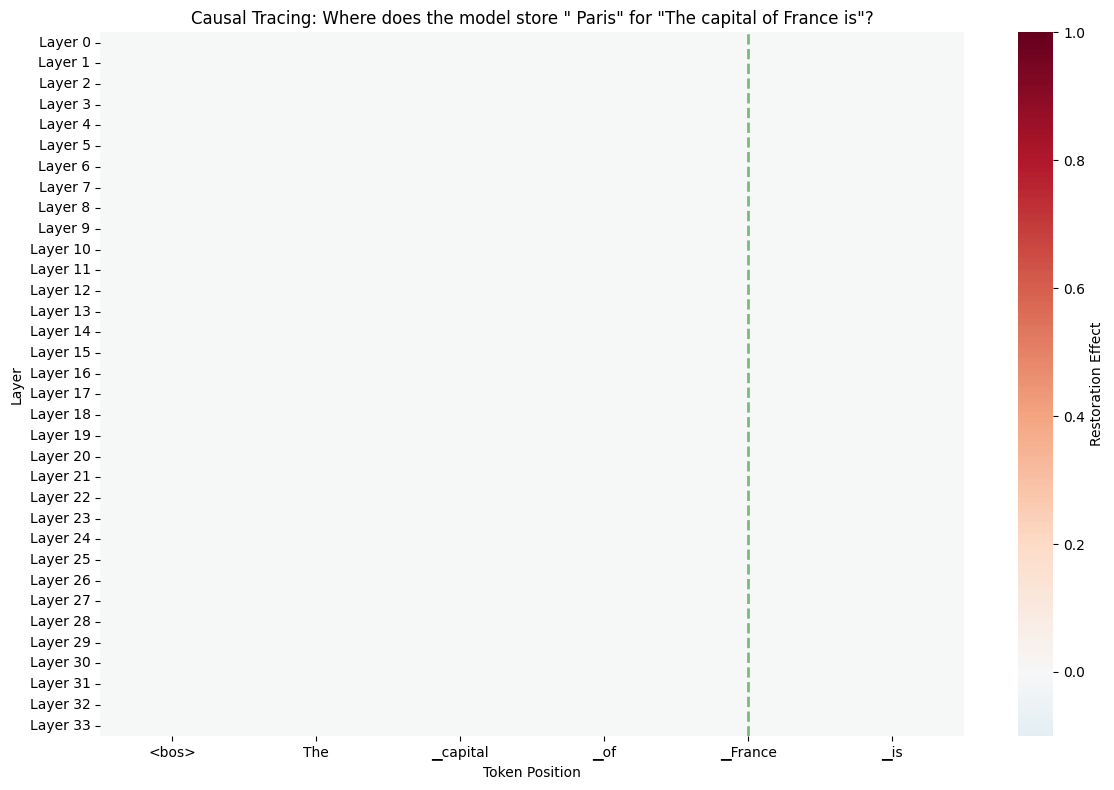


Most causally important positions (layer, position, effect):


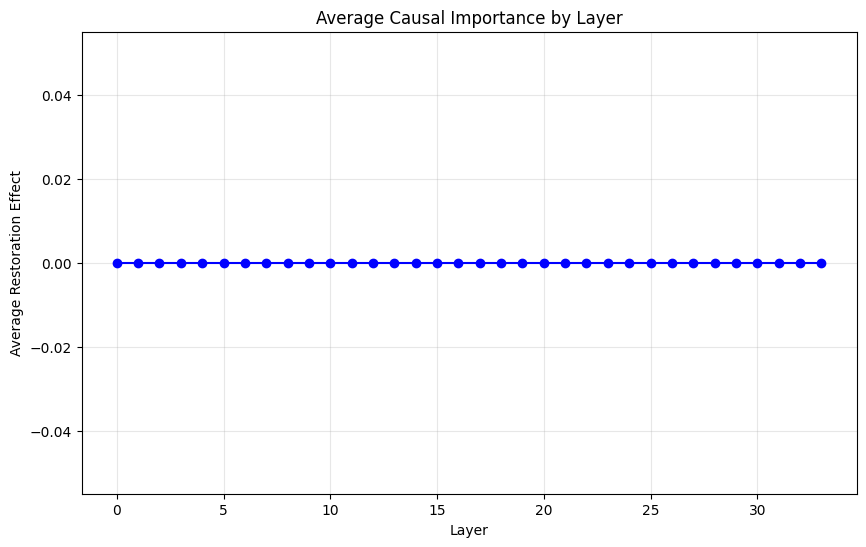

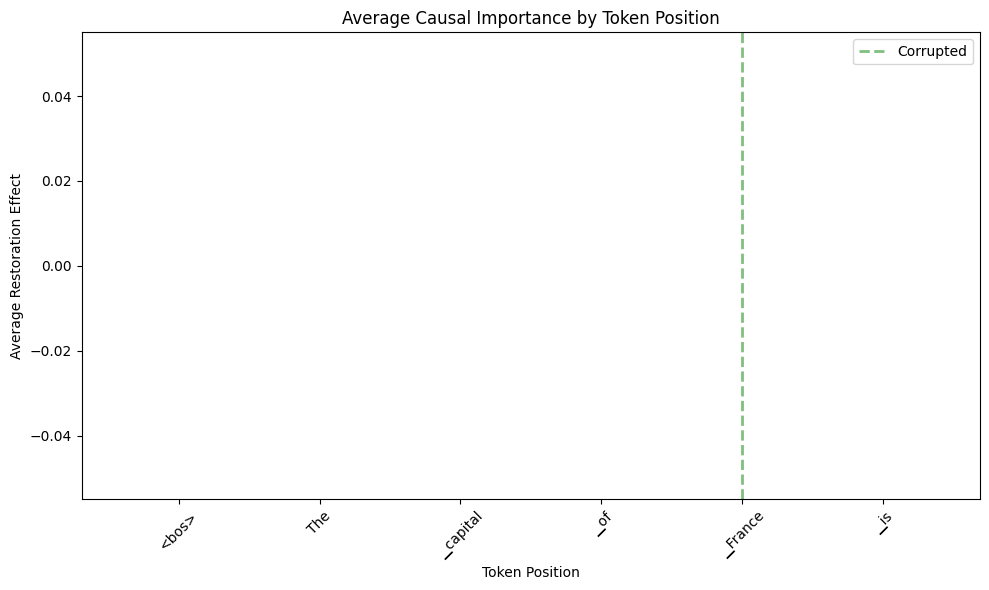

In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict
import gc

# Load model and tokenizer
model_name = "google/gemma-3-4b-it"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto"
)
model.eval()

# Print model architecture to understand its structure
print(f"Model type: {type(model)}")
print(f"Model attributes: {[attr for attr in dir(model) if not attr.startswith('_')][:10]}")
if hasattr(model, 'model'):
    print(f"Model.model attributes: {[attr for attr in dir(model.model) if not attr.startswith('_')][:10]}")

# Define the factual prompt
prompt = "The capital of France is"
target_answer = " Paris"

# Tokenize inputs
clean_inputs = tokenizer(prompt, return_tensors="pt").to(device)
target_token_id = tokenizer.encode(target_answer, add_special_tokens=False)[0]

print(f"Prompt: '{prompt}'")
print(f"Expected answer: '{target_answer}' (token_id: {target_token_id})")

# Create corrupted input by adding noise to embeddings
def create_corrupted_input(model, clean_inputs, noise_level=3.0):
    """Create corrupted input by adding Gaussian noise to the subject tokens"""
    tokens = tokenizer.convert_ids_to_tokens(clean_inputs.input_ids[0])
    print(f"Tokens: {tokens}")
    
    # Find positions to corrupt (e.g., "France")
    corrupt_positions = []
    for i, token in enumerate(tokens):
        if "France" in token or "france" in token.lower():
            corrupt_positions.append(i)
    
    if not corrupt_positions:
        # If "France" not found as single token, corrupt positions near the end
        corrupt_positions = list(range(max(0, len(tokens)-3), len(tokens)-1))
    
    print(f"Corrupting positions: {corrupt_positions}")
    
    # Get embeddings
    embeddings = model.get_input_embeddings()
    clean_embeds = embeddings(clean_inputs.input_ids)
    
    # Add noise to specific positions
    corrupted_embeds = clean_embeds.clone()
    for pos in corrupt_positions:
        noise = torch.randn_like(corrupted_embeds[0, pos, :]) * noise_level
        corrupted_embeds[0, pos, :] += noise
    
    return corrupted_embeds, corrupt_positions

# Function to run forward pass with custom embeddings
def forward_with_embeddings(model, embeddings, attention_mask=None):
    """Run forward pass using provided embeddings instead of token ids"""
    return model(inputs_embeds=embeddings, attention_mask=attention_mask, 
                 output_hidden_states=True, use_cache=False)

# Create corrupted embeddings
corrupted_embeds, corrupt_positions = create_corrupted_input(model, clean_inputs)

# Run clean forward pass
print("\nRunning clean forward pass...")
with torch.no_grad():
    clean_outputs = model(**clean_inputs, output_hidden_states=True, use_cache=False)
    clean_hidden_states = clean_outputs.hidden_states
    clean_logits = clean_outputs.logits[0, -1, :]
    clean_prob = F.softmax(clean_logits, dim=-1)[target_token_id].item()
    clean_prediction = torch.argmax(clean_logits).item()
    print(f"Clean prediction: '{tokenizer.decode(clean_prediction)}' (prob of Paris: {clean_prob:.3f})")

# Run corrupted forward pass
print("\nRunning corrupted forward pass...")
with torch.no_grad():
    corrupted_outputs = forward_with_embeddings(model, corrupted_embeds, clean_inputs.attention_mask)
    corrupted_logits = corrupted_outputs.logits[0, -1, :]
    corrupted_prob = F.softmax(corrupted_logits, dim=-1)[target_token_id].item()
    corrupted_prediction = torch.argmax(corrupted_logits).item()
    print(f"Corrupted prediction: '{tokenizer.decode(corrupted_prediction)}' (prob of Paris: {corrupted_prob:.3f})")

# Causal tracing main loop
def causal_trace_analysis(model, clean_inputs, corrupted_embeds, clean_hidden_states, target_token_id):
    """Perform causal tracing by restoring clean activations at each position"""
    num_layers = len(clean_hidden_states) - 1  # Exclude embedding layer
    seq_len = clean_hidden_states[0].shape[1]
    
    # Store results
    restoration_effects = np.zeros((num_layers, seq_len))
    
    print(f"\nPerforming causal tracing across {num_layers} layers and {seq_len} positions...")
    
    # Function to get the correct layer module
    def get_layer_module(model, layer_idx):
        if hasattr(model, 'model') and hasattr(model.model, 'layers'):
            return model.model.layers[layer_idx]
        elif hasattr(model, 'transformer') and hasattr(model.transformer, 'h'):
            return model.transformer.h[layer_idx]
        elif hasattr(model, 'bert') and hasattr(model.bert, 'encoder') and hasattr(model.bert.encoder, 'layer'):
            return model.bert.encoder.layer[layer_idx]
        else:
            raise AttributeError(f"Cannot find layers in model of type {type(model)}")
    
    # Function to patch hidden states at specific layer and position
    def create_patched_forward(layer_idx, position_idx, clean_state):
        def forward_fn(inputs_embeds, attention_mask=None):
            # Hook to replace activation
            def patch_hook(module, input, output):
                # Handle different output formats
                if isinstance(output, tuple):
                    hidden_states = output[0]
                else:
                    hidden_states = output
                
                # Clone and patch
                hidden_states = hidden_states.clone()
                hidden_states[0, position_idx, :] = clean_state[0, position_idx, :]
                
                # Return in same format
                if isinstance(output, tuple):
                    return (hidden_states,) + output[1:]
                return hidden_states
            
            # Register hook at the target layer
            layer_module = get_layer_module(model, layer_idx)
            hook_handle = layer_module.register_forward_hook(patch_hook)
            
            # Run forward pass
            with torch.no_grad():
                outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask, use_cache=False)
            
            # Remove hook
            hook_handle.remove()
            
            return outputs
        
        return forward_fn
    
    # Test each (layer, position) combination
    for layer_idx in range(num_layers):
        if layer_idx % 5 == 0:
            print(f"Processing layer {layer_idx}/{num_layers-1}...")
        
        for pos_idx in range(seq_len):
            # Get clean hidden state for this layer (layer_idx + 1 because of embedding layer)
            clean_state = clean_hidden_states[layer_idx + 1]
            
            # Create patched forward function
            patched_forward = create_patched_forward(layer_idx, pos_idx, clean_state)
            
            # Run with patched activation
            try:
                outputs = patched_forward(corrupted_embeds, clean_inputs.attention_mask)
                patched_logits = outputs.logits[0, -1, :]
                patched_prob = F.softmax(patched_logits, dim=-1)[target_token_id].item()
                
                # Calculate restoration effect
                restoration = (patched_prob - corrupted_prob) / (clean_prob - corrupted_prob + 1e-10)
                restoration_effects[layer_idx, pos_idx] = restoration
            except Exception as e:
                print(f"Error at layer {layer_idx}, position {pos_idx}: {e}")
                restoration_effects[layer_idx, pos_idx] = 0
            
            # Clear GPU cache periodically
            if torch.cuda.is_available() and pos_idx % 10 == 0:
                torch.cuda.empty_cache()
    
    return restoration_effects

# Run causal tracing
restoration_effects = causal_trace_analysis(
    model, clean_inputs, corrupted_embeds, clean_hidden_states, target_token_id
)

# Visualization
plt.figure(figsize=(12, 8))
tokens = tokenizer.convert_ids_to_tokens(clean_inputs.input_ids[0])

# Create heatmap
sns.heatmap(restoration_effects, 
            cmap='RdBu_r', 
            center=0, 
            vmin=-0.1, 
            vmax=1.0,
            xticklabels=tokens,
            yticklabels=[f"Layer {i}" for i in range(len(restoration_effects))],
            cbar_kws={'label': 'Restoration Effect'})

plt.xlabel('Token Position')
plt.ylabel('Layer')
plt.title(f'Causal Tracing: Where does the model store "{target_answer}" for "{prompt}"?')

# Highlight corrupted positions
for pos in corrupt_positions:
    plt.axvline(x=pos + 0.5, color='green', linestyle='--', alpha=0.5, linewidth=2)

plt.tight_layout()
plt.show()

# Find most important positions
important_positions = []
threshold = 0.3  # Lowered threshold
for layer_idx, row in enumerate(restoration_effects):
    for pos_idx, effect in enumerate(row):
        if effect > threshold:
            important_positions.append((layer_idx, pos_idx, effect))

# Sort by effect strength
important_positions.sort(key=lambda x: x[2], reverse=True)

print("\nMost causally important positions (layer, position, effect):")
for layer, pos, effect in important_positions[:10]:
    token = tokens[pos] if pos < len(tokens) else "<PAD>"
    print(f"Layer {layer:2d}, Position {pos:2d} ('{token:15s}'): {effect:.3f}")

# Plot average effect per layer
plt.figure(figsize=(10, 6))
avg_per_layer = restoration_effects.mean(axis=1)
plt.plot(range(len(avg_per_layer)), avg_per_layer, 'b-o')
plt.xlabel('Layer')
plt.ylabel('Average Restoration Effect')
plt.title('Average Causal Importance by Layer')
plt.grid(True, alpha=0.3)
plt.show()

# Plot average effect per position
plt.figure(figsize=(10, 6))
avg_per_position = restoration_effects.mean(axis=0)
plt.bar(range(len(tokens)), avg_per_position)
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.xlabel('Token Position')
plt.ylabel('Average Restoration Effect')
plt.title('Average Causal Importance by Token Position')

# Highlight corrupted positions
for pos in corrupt_positions:
    plt.axvline(x=pos, color='green', linestyle='--', alpha=0.5, linewidth=2, 
                label='Corrupted' if pos == corrupt_positions[0] else '')
if corrupt_positions:
    plt.legend()

plt.tight_layout()
plt.show()